In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GaussianNoise, GlobalMaxPooling2D
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [3]:
#Downloading dataset
!kaggle datasets download -d vuppalaadithyasairam/bone-fracture-detection-using-xrays

 95% 163M/172M [00:02<00:00, 67.7MB/s]
100% 172M/172M [00:02<00:00, 70.0MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/bone-fracture-detection-using-xrays.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
#Loading the images
x_train= keras.utils.image_dataset_from_directory(
    directory = '/content/archive (6)/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=100,
    image_size=(256,256)
)

x_test= keras.utils.image_dataset_from_directory(
    directory = '/content/archive (6)/val',
    labels='inferred',
    label_mode = 'int',
    batch_size=100,
    image_size=(256,256)
)

Found 8863 files belonging to 2 classes.
Found 600 files belonging to 2 classes.


In [6]:
class_names = x_train.class_names
class_names

['fractured', 'not fractured']

In [7]:
# Normalizing
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

x_train = x_train.map(process)
x_test = x_test.map(process)

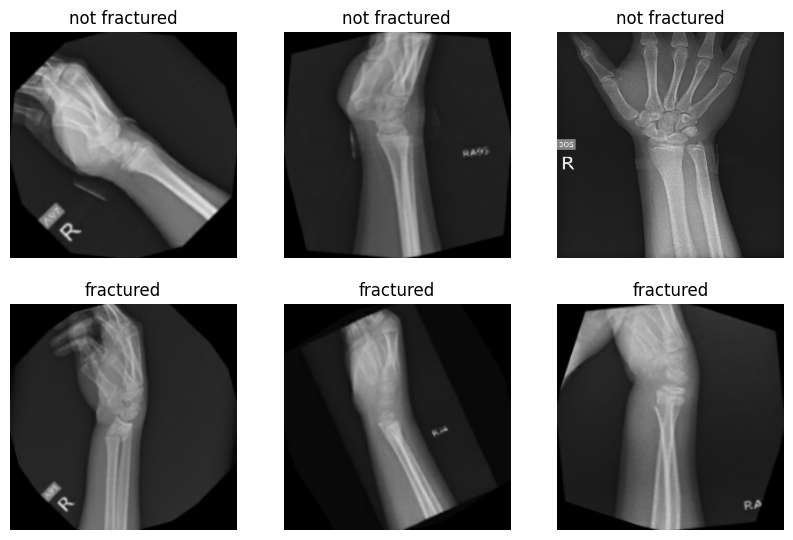

In [ ]:
# Display a few sample images from train
plt.figure(figsize=(10, 10))
for images, labels in x_train.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

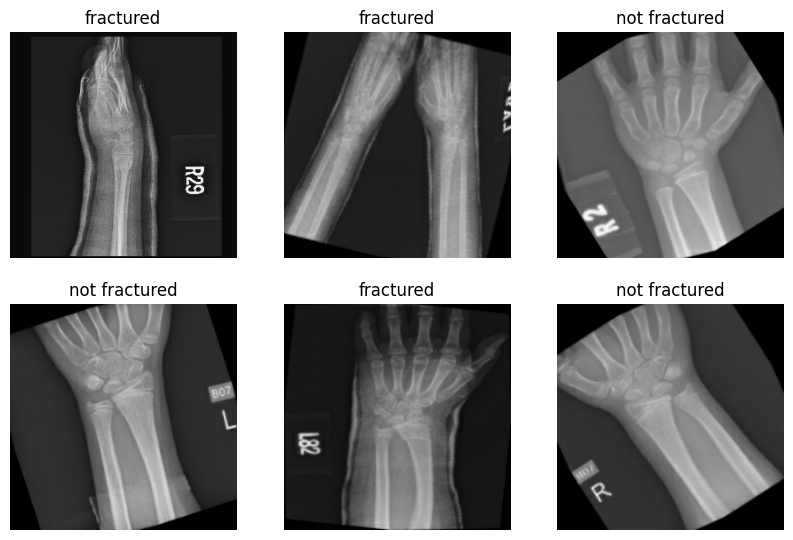

In [ ]:
# Display a few sample images from test
plt.figure(figsize=(10, 10))
for images, labels in x_test.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [8]:
input = (256, 256, 3)

In [9]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model

In [10]:
# Creating the base model
base_model = InceptionV3(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.25)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
history = model.fit(x_train,epochs=10, batch_size=100, validation_data=x_test)

Epoch 1/10
89/89 [==============================] - 50s 350ms/step - loss: 0.5420 - accuracy: 0.7328 - val_loss: 0.6243 - val_accuracy: 0.6617
Epoch 2/10
89/89 [==============================] - 29s 308ms/step - loss: 0.3419 - accuracy: 0.8534 - val_loss: 0.5632 - val_accuracy: 0.6933
Epoch 3/10
89/89 [==============================] - 28s 305ms/step - loss: 0.2523 - accuracy: 0.9053 - val_loss: 0.5197 - val_accuracy: 0.7383
Epoch 4/10
89/89 [==============================] - 28s 305ms/step - loss: 0.1956 - accuracy: 0.9341 - val_loss: 0.5211 - val_accuracy: 0.7367
Epoch 5/10
89/89 [==============================] - 28s 305ms/step - loss: 0.1646 - accuracy: 0.9446 - val_loss: 0.6001 - val_accuracy: 0.7217
Epoch 6/10
89/89 [==============================] - 28s 305ms/step - loss: 0.1244 - accuracy: 0.9620 - val_loss: 0.5745 - val_accuracy: 0.7383
Epoch 7/10
89/89 [==============================] - 28s 308ms/step - loss: 0.1100 - accuracy: 0.9692 - val_loss: 0.5314 - val_accuracy: 0.7633

In [21]:
#Predicting
image_path = "/content/Fractured.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(image, (256, 256))
normalized_image = resized_image / 255.0
input_image = np.expand_dims(normalized_image, axis=0)

prediction = model.predict(input_image)[0]
is_fractured = prediction >= 0.5

if is_fractured:
    print("Fractured")
else:
    print("Not Fractured")

1/1 [==============================] - 0s 27ms/step
Fractured


In [34]:
#Using Contour
def box(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_image = cv2.resize(image, (256, 256))
    normalized_image = resized_image / 255.0
    input_image = np.expand_dims(normalized_image, axis=0)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_image = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Finding contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        contour = max(contours, key=cv2.contourArea)

        x, y, width, height = cv2.boundingRect(contour)
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 0, 255), 2)

    # Display the image with the red box
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

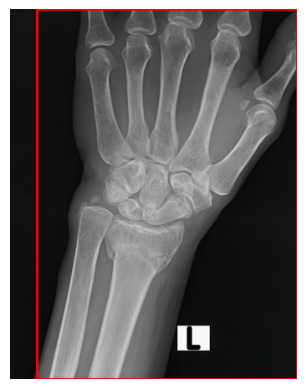

In [36]:
image_path = "/content/Fracture.jpeg"
box(image_path)